In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from utils import load_meters_data, prepare_data

In [20]:
df = load_meters_data(esave_path="data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls")
#df = prepare_data(df, time_steps=None, split_ratio=0)
df.dropna(axis=1, inplace=True)
channels = df.shape[1]

In [9]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# grangers_causation_matrix(df, variables = df.columns)

In [6]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# cointegration_test(df)

In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [10]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "707057500068119547" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9604
 No. Lags Chosen       = 55
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "707057500068755066" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.1564
 No. Lags Chosen       = 51
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ESAVE_193681-980396002_EAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

(43848,)
(43848,)
    Augmented Dickey-Fuller Test on "averaged-24hr" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9604
 No. Lags Chosen       = 55
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


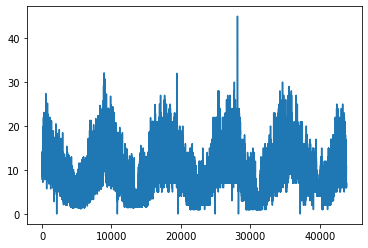

In [11]:
x = df.values[:,0]
print(x.shape)
avgResult = np.average(x.reshape(-1, 1), axis=1)
print(avgResult.shape)
plt.plot(avgResult)
adfuller_test(avgResult, name="averaged-24hr")

In [21]:
model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1


LinAlgError: 126-th leading minor of the array is not positive definite

In [13]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,24.85,24.86,6.219e+10,24.85
1,15.46,15.47,5.157e+06,15.46
2,14.60,14.63,2.193e+06,14.61
3,14.47,14.52,1.924e+06,14.49
4,14.36,14.42,1.716e+06,14.38
5,14.28,14.37,1.597e+06,14.31
6,14.22,14.32,1.504e+06,14.25
7,14.13,14.24,1.367e+06,14.16
8,14.06,14.19,1.277e+06,14.10
9,13.98,14.12,1.175e+06,14.02


In [14]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Mar, 2022
Time:                     18:00:50
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    14.6354
Nobs:                     43846.0    HQIC:                   14.6122
Log likelihood:          -879870.    FPE:                2.19454e+06
AIC:                      14.6015    Det(Omega_mle):     2.18600e+06
--------------------------------------------------------------------
Results for equation 707057500068119547
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.644610         0.018076           35.662           0.000
L1.707057500068119547                 0.549382         0.005539           99.189

In [15]:
def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

707057500068119547 : 2.01
707057500068755066 : 1.95
ESAVE_193681-980396002_EAN : 2.02
707057500068789658 : 2.01
707057500068425556 : 2.03
707057500068402960 : 2.0
707057500068104048 : 1.93
707057500068744237 : 2.01
707057500068750269 : 2.0


[[ 7.  3.  7.  6.  6. 13. 11. 16.  3.]
 [ 7.  3.  7.  5.  7. 11. 10. 14.  2.]]
[[ 7.02117201  3.41661143  7.50505708  5.30615889  6.42685899 10.27957285
   9.77997561 13.75677383  4.0723041 ]]


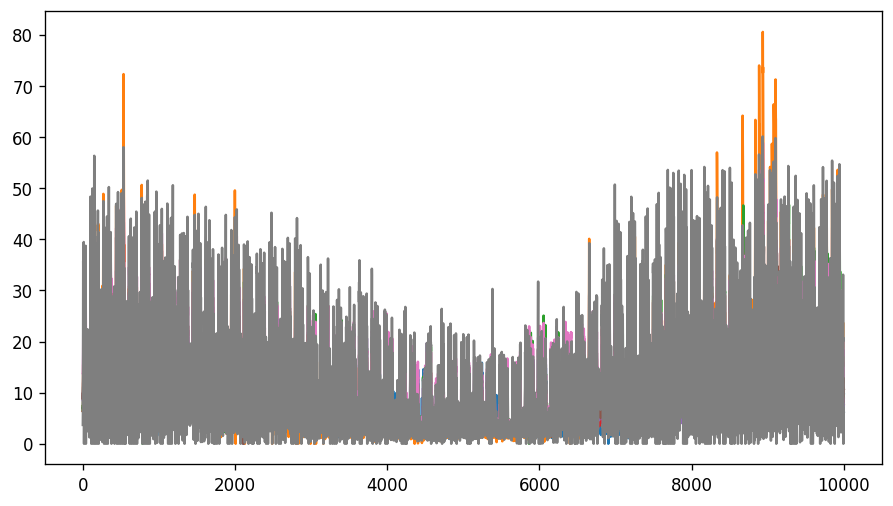

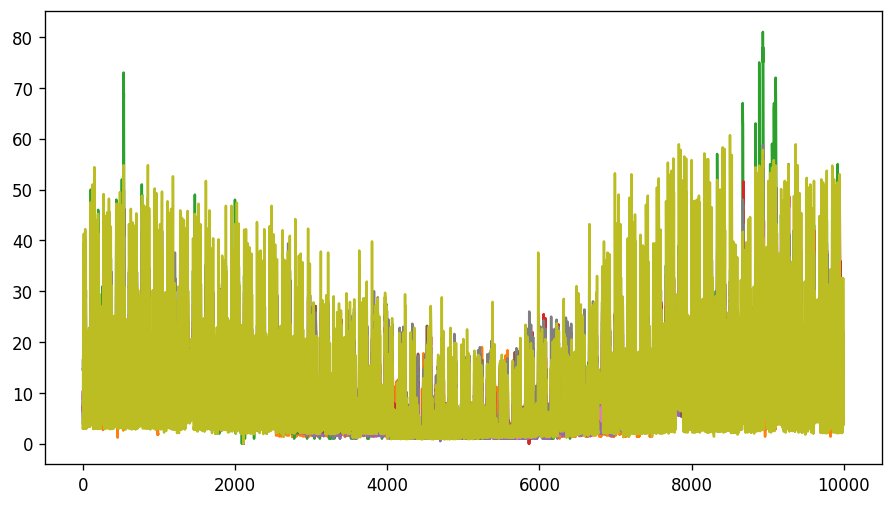

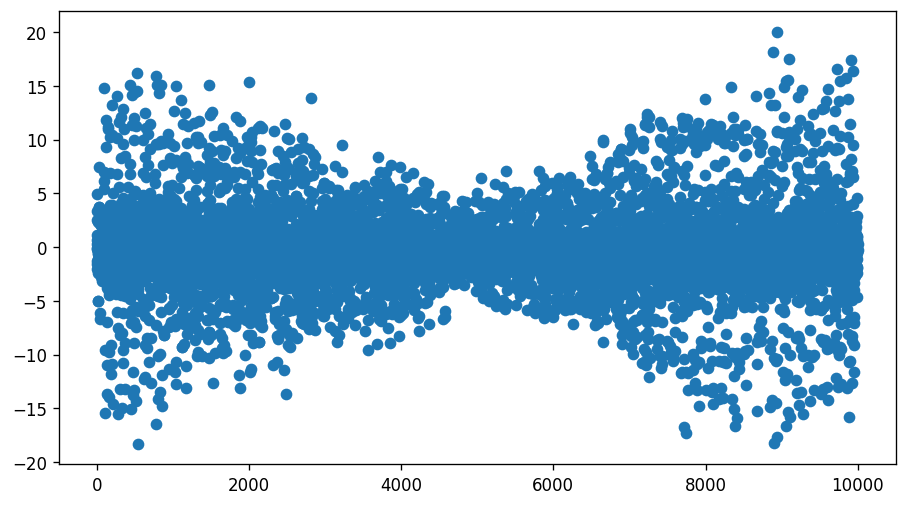

In [19]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df.values[-lag_order:]
print(forecast_input)

fc = model_fitted.forecast(y=forecast_input, steps=1)
plt.plot(fc)
print(fc)

fcs = []
for i in range(10000):
    forecast_input = df.values[i:i+lag_order]
    fc = model_fitted.forecast(y=forecast_input, steps=1)
    fc[np.where(fc < 0)] = 0
    fcs.append(fc.reshape(9))
    
fcs = np.stack(fcs)
plt.plot(fcs)
plt.show()
plt.plot(df.values[:10000])
plt.show()
res = np.mean(fcs - df.values[:10000], axis=1)
plt.scatter(range(10000), res)
plt.show()

In [60]:
df

,707057500068119547,707057500068755066,ESAVE_193681-980396002_EAN,707057500068789658,707057500068425556,707057500068402960,707057500068104048,707057500068744237,707057500068750269,707057500067764427,707057500068631728,707057500068720545,707057500068794539,ESAVE_224511-980396002_EAN,707057500068799404,ESAVE_241160-980396002_EAN,707057500068615506,707057500068755769,707057500068769384,ESAVE_193683-980396002_EAN,707057500068728855,ESAVE_179800-980396002_EAN,707057500068860340,ESAVE_280155-980396002_EAN,707057500068762231,707057500068766611,707057500068865116,707057500067807612,707057500067807636,707057500068615018,707057500067747925,707057500068613267,707057500068704231,707057500068016693,707057500068834891,ESAVE_279626-980396002_EAN,707057500068741793,ESAVE_179883-980396002_EAN,707057500068605279,707057500068263301,...,707057500068614707,707057500068449538,707057500068449545,707057500068449552,707057500068449569,707057500068882557,707057500068957880,707057500068957897,707057500068285990,707057500068563876,707057500068617289,707057500068635016,707057500068709168,707057500068799947,707057500068614547,ESAVE_86192-980396002_EAN,707057500068614752,ESAVE_225538-980396002_EAN,707057500068790548,707057500068823680,707057500068823697,707057500068823703,707057500068823710,707057500068823727,707057500068823734,707057500068823741,707057500068564491,707057500068613014,707057500068898756,ESAVE_280233-980396002_EAN,707057500068890699,707057500068906314,ESAVE_283078-980396002_EAN,707057500068616404,707057500068820887,ESAVE_235940-980396002_EAN,ESAVE_277703-980396002_EAN,ESAVE_280180-980396002_EAN,707057500068858477,ESAVE_280058-980396002_EAN
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,9.4,7.2,8.0,7.1,4.0,6.7,9.9,14.6,4.7,4.7,4.6,15.2,1.5,16.0,4.1,4.0,15.4,4.4,19.0,36.0,6.2,9.0,8.0,17.0,5.6,7.8,3.2,0.0,7.2,13.0,7.9,17.0,6.2,5.3,3.2,11.0,1.9,17.0,4.2,1.4,...,48.0,2.4,24.8,36.0,49.2,4.8,0.0,0.0,2.5,40.0,8.2,46.2,38.8,6.2,44.0,24.0,16.0,55.0,12.2,7.8,11.4,7.2,10.2,4.2,6.0,7.2,20.8,26.0,60.8,97.0,20.8,26.0,140.0,145.6,64.0,5.0,104.0,60.0,90.0,120.0
2015-01-01 01:00:00,9.6,7.2,9.0,7.0,7.0,8.6,10.0,14.6,2.9,3.8,3.7,15.4,1.5,17.0,4.3,4.0,14.0,4.4,18.0,34.0,5.0,12.0,0.0,15.0,5.5,8.0,1.6,0.0,7.0,11.0,7.9,17.0,5.6,5.9,3.2,9.0,1.8,12.0,3.9,1.7,...,50.0,2.2,28.8,40.0,48.4,4.8,0.0,0.0,3.0,47.6,8.2,46.2,45.6,6.2,48.0,37.0,12.0,59.0,11.8,9.6,9.0,7.2,10.2,4.2,4.8,7.2,20.0,25.6,68.8,105.0,19.2,24.0,140.0,145.2,120.0,5.0,108.0,50.0,87.0,110.0
2015-01-01 02:00:00,8.7,7.2,9.0,6.2,6.0,10.4,8.8,15.0,3.2,4.0,3.7,16.4,1.5,16.0,4.7,11.0,14.7,11.0,16.6,36.0,7.2,12.0,0.0,14.0,6.1,8.0,3.2,0.0,7.3,13.0,8.4,17.0,4.7,5.8,3.2,7.0,1.9,11.0,3.9,1.6,...,52.0,2.4,25.6,40.0,51.2,3.2,0.0,0.0,2.5,46.4,8.0,46.6,46.4,6.4,48.0,95.0,16.0,64.0,11.8,7.8,10.2,7.2,10.2,5.4,5.4,8.4,66.4,25.2,64.0,101.0,17.6,24.0,140.0,152.0,72.0,6.0,111.0,100.0,90.0,120.0
2015-01-01 03:00:00,8.8,7.2,9.0,7.8,5.0,10.2,10.2,16.6,5.3,3.8,3.7,16.0,1.5,17.0,4.3,9.0,13.8,21.4,16.2,34.0,7.8,11.0,8.0,13.0,5.5,7.6,1.6,0.0,7.0,12.0,8.6,17.0,6.2,7.2,3.2,7.0,1.9,10.0,3.6,1.6,...,52.0,2.2,26.4,36.0,48.4,4.8,0.0,0.0,2.5,46.4,8.0,46.2,39.2,6.1,44.0,48.0,16.0,61.0,12.2,6.6,10.2,7.2,10.2,4.2,5.4,7.8,29.6,26.4,60.8,98.0,16.0,24.0,140.0,150.0,32.0,10.0,116.0,110.0,87.0,120.0
2015-01-01 04:00:00,9.1,7.2,9.0,7.0,5.0,9.8,9.9,15.4,18.2,4.2,4.7,16.2,1.5,17.0,4.3,10.0,14.6,12.1,17.6,36.0,6.6,17.0,0.0,13.0,5.8,7.7,3.2,0.0,7.0,20.0,8.4,16.0,12.6,5.9,3.2,10.0,1.8,9.0,3.9,3.4,...,54.0,2.2,25.6,40.0,50.0,4.8,0.0,0.0,2.5,45.6,8.2,46.2,41.6,6.5,44.0,53.0,16.0,75.0,11.9,7.2,10.2,7.2,10.2,4.2,5.4,7.8,28.0,25.6,52.8,97.0,17.6,24.0,150.0,161.2,76.0,12.0,113.0,70.0,99.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [75]:
daily = df.resample('D').sum() + 1
# get first 3 columns
daily = daily.iloc[:, :3]
daily

,707057500068119547,707057500068755066,ESAVE_193681-980396002_EAN
datetime,,,
2015-01-01,260.7,169.6,296.0
2015-01-02,258.3,169.8,310.0
2015-01-03,244.4,168.0,264.0
2015-01-04,252.6,168.8,305.0
2015-01-05,303.6,301.8,589.0
...,...,...,...
2019-12-28,242.0,177.0,257.0
2019-12-29,189.0,164.0,199.0
2019-12-30,223.0,281.0,419.0


In [89]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR

model = VARMAX(daily, order=(3,3))
model_fit = model.fit(disp=True)
lag_order = model_fitted.k_ar
print(lag_order)

C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14


ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 1, 3)

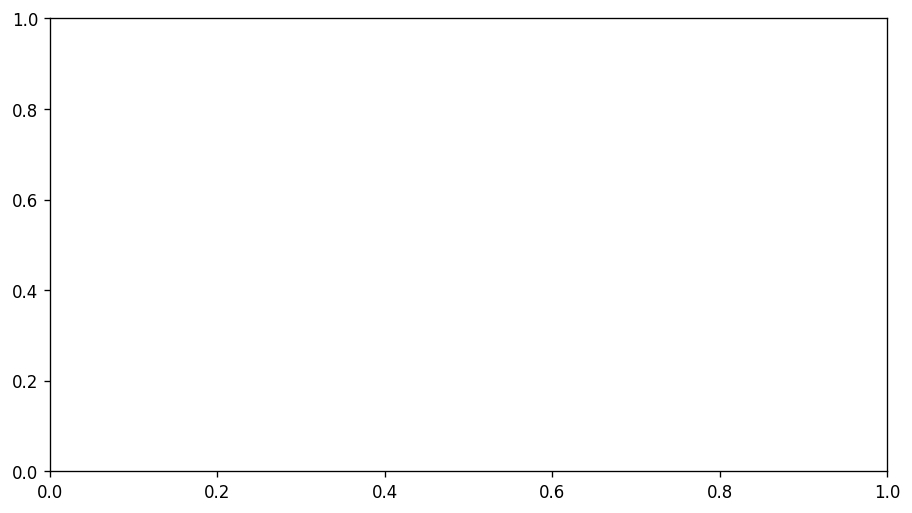

In [93]:
forecast_input = daily.iloc[-lag_order:]
print(forecast_input.shape)
fc = model_fit.forecast(y=forecast_input, steps=365)
plt.plot(fc)
print(fc.shape)

In [96]:
import pmdarima as pm

# get first column
y = daily.iloc[:, 0].values

model = pm.auto_arima(y, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19337.359, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19897.116, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19682.808, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19438.328, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19895.117, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19338.514, Time=1.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19338.915, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19346.734, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19621.421, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19327.222, Time=0.84 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19313.929, Time=1.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19311.826, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19529.667, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=19309.831, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0

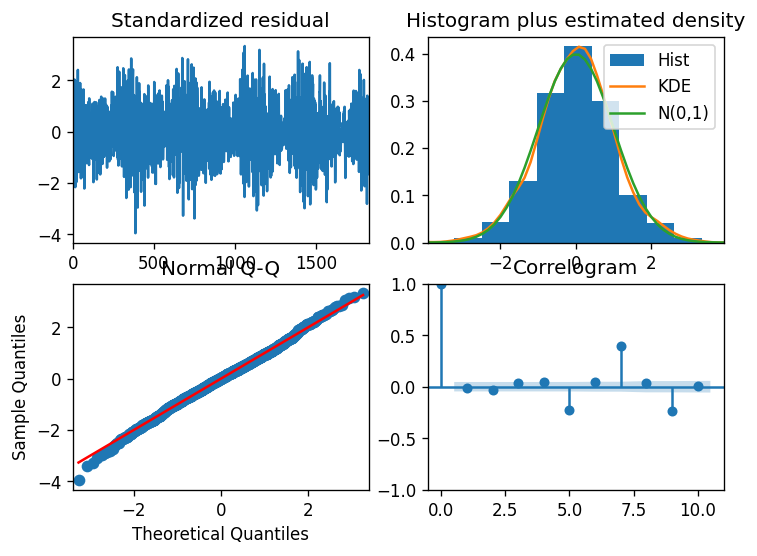

In [97]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

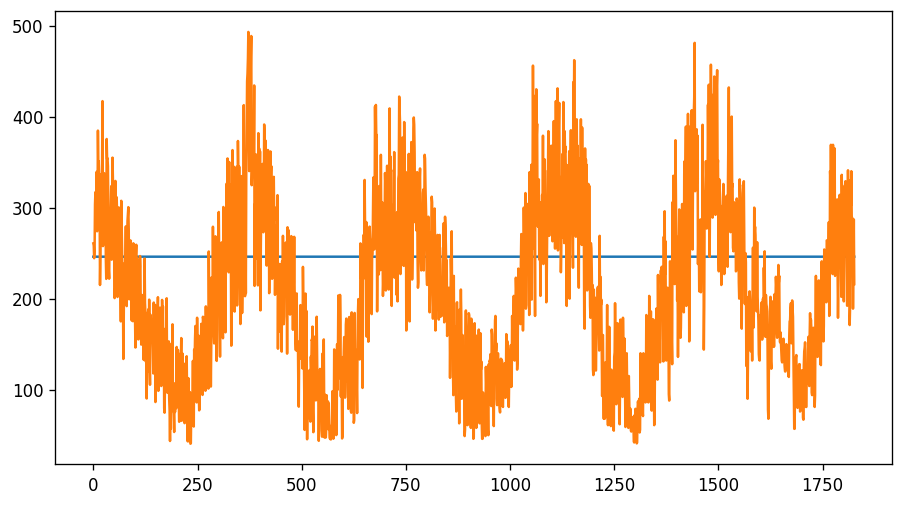

In [102]:
# test how good model fitted
predictions = []
for i in range(len(y)):
    predictions.append(model.predict(n_periods=1, exog=y[:i+1]))

# print prediction
plt.plot(predictions)
# print actual
plt.plot(y)
